In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from data_viz_functions import *

In [59]:
train = pd.read_csv('kaggle/input/train.csv', index_col='client_id')
test = pd.read_csv('kaggle/input/test.csv', index_col='client_id')
sub_sample = pd.read_csv('kaggle/input/sample_submission.csv')

# столбец с датой удалим, т.к. интуитивно он не может сильно влиять на вероятность дефолта
# (учитывая, что все данные по 2014ому году)

train.drop(columns=['app_date'], inplace=True)
test.drop(columns=['app_date'], inplace=True)

num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', ]
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

train.info()
test.info()
sub_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 25905 to 15796
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73492 non-null  object 
 1   sex               73799 non-null  object 
 2   age               73799 non-null  int64  
 3   car               73799 non-null  object 
 4   car_type          73799 non-null  object 
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  int64  
 9   region_rating     73799 non-null  int64  
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  int64  
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  object 
 16  default           73799 non-null  in

# Предобработка данных

## Пропуски в данных

В обеих выборках пропуски присутствуют только в столбце ```education```

В целом доля пропусков довольно незначительна (в обеих примерно по 0.4%)

Таким образом, заполним пропуски наиболее популярным значением (модой) и потратим временные ресурсы на проработку моделей

In [60]:
train['education'].fillna(train['education'].mode().values[0], inplace=True)

# чтобы не менять параметры распределения, заполним пропуски в test тем же значением, что и в train
test['education'].fillna(train['education'].mode().values[0], inplace=True) 

# make sure na was filled
print(train.isna().sum(), test.isna().sum())

education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
dtype: int64 education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
dtype: int64


## Визуализация данных

Визуализируем числовые признаки, чтобы понять, какие из них нуждаются в логарифмировании, а какие - нет

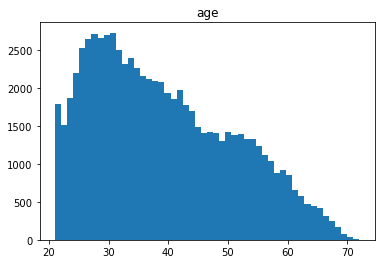

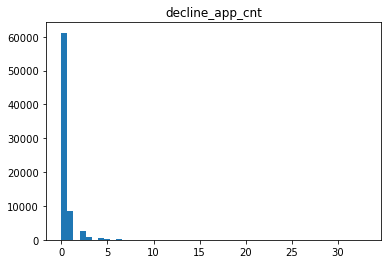

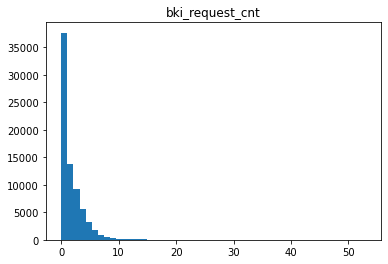

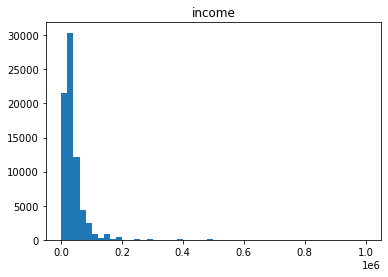

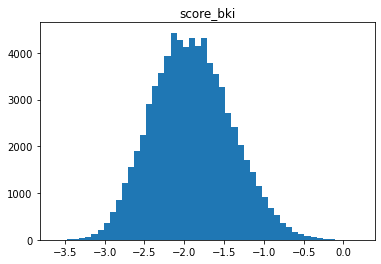

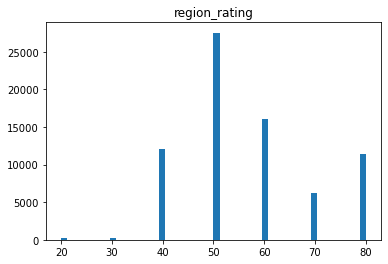

In [61]:
for col in num_cols:
    plt.hist(train[col], bins=50)
    plt.title(col)
    plt.show()

### Вывод

Попробуем логарифмировать все признаки, кроме ```score_bki```, т.к. распределение этого признака выглядит довольно похожим на нормальное

### Логарифмирование и удаление выбросов

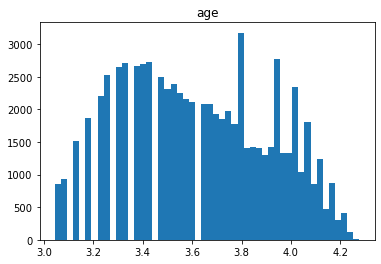

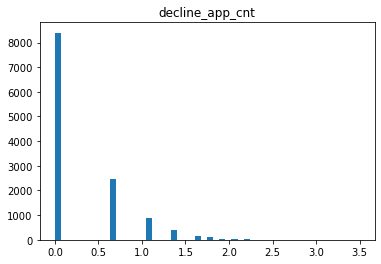

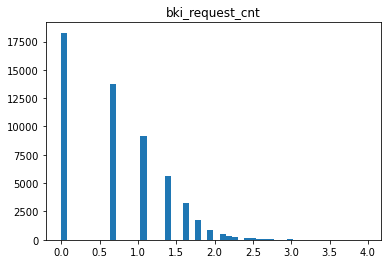

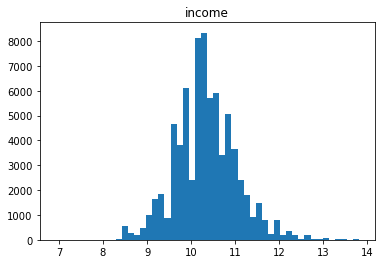

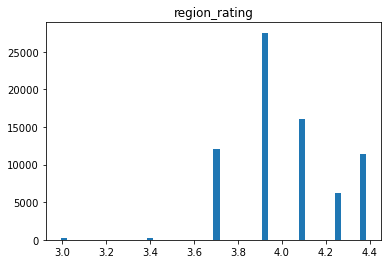

In [62]:
for col in num_cols:
    
    if col != 'score_bki':
        plt.hist(np.log(train[col][train[col] > 0].dropna()), bins=50)
        plt.title(col)
        plt.show()

### Вывод - 2

Из построенных графиков видим, что значительно меняет свое распределение только признак ```income```, остальные остаются похожими на первоначальные распределения, при том, что часть данных теряется из-за ```dropna()```, т.к. например, в переменных ```decline_app_cnt, bki_request_cnt``` визуально заметно, что наиболее популярные значения - 0, в котором логарифм не определен

**Логарифмируем переменную ```income```, остальные не меняем**

Потеряли наблюдений: 642


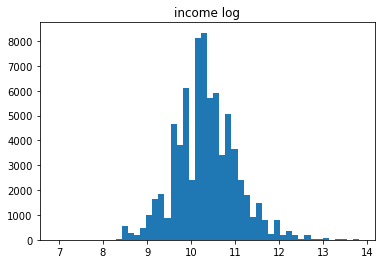

In [63]:
# предварительно избавимся от выбросов в переменной income (выявили их после визуального анализа)
std, q25, q75 = train['income'].std(), *train['income'].quantile([.25, .75]).values.tolist()

temp = train.loc[
    (train['income'] >= (q25 - 4 * std)) &
    (train['income'] <= (q75 + 4 * std))
]

print(f'Потеряли наблюдений: {train.shape[0] - temp.shape[0]}')
# получается, что такое удаление выбросов удаляет >1к наблюдений, слишком большая потеря
# изменение количества станд. откл. не сильно влияет на количество найденных выбросов
# поэтому оставим данные без удаления выбросов
# В других числовых признаках удаление выбросов также приводит к потере большого кол-ва строк

train['income'] = np.log(train['income'])
test['income'] = np.log(test['income'])

plt.hist(train['income'], bins=50)
plt.title('income log')
plt.show()

### Корреляция числовых признаков

<AxesSubplot:>

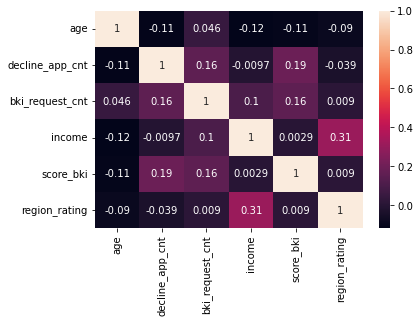

In [64]:
sns.heatmap(train[num_cols].corr(), annot=True)

### Вывод

Заметно, что признаки ```income``` и ```region_rating``` коррелируют довольно сильно, однако ```income``` несет в себе больше информации, т.к. ```region_rating``` - дискретный признак с небольшим количеством возможных значений, следовательно, ```region_rating``` удаляем

In [65]:
train.drop(columns=['region_rating'],  inplace=True)
test.drop(columns=['region_rating'],  inplace=True)
num_cols.pop(num_cols.index('region_rating'))

'region_rating'

## Определение важности признаков

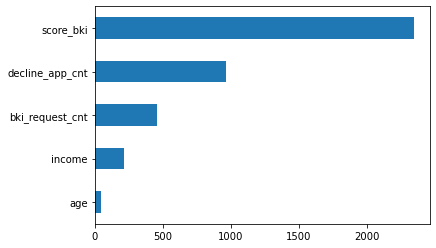

In [66]:
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index=num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.show()

### Вывод

Наиболее значимым признаком в отношении вероятности дефолта оказывается ```score_bki```, а наименее - возраст объекта.

## Масштабирование и кодировка категориальных признаков

<AxesSubplot:>

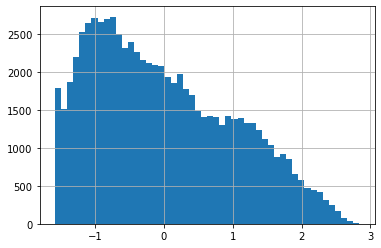

In [67]:
# Масштабировани числовых признаков
sc = StandardScaler()
# обучаемся на только на train
sc.fit(train[num_cols])

train.loc[:, num_cols] = sc.transform(train[num_cols])
test.loc[:, num_cols] = sc.transform(test[num_cols])

train['age'].hist(bins=50)


In [68]:
# Кодировка категориальных и бинарных признаков
train = pd.get_dummies(train, columns=cat_cols + bin_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols + bin_cols, drop_first=True)

In [69]:
train

,age,decline_app_cnt,score_bki,bki_request_cnt,income,default,education_GRD,education_PGR,education_SCH,education_UGR,...,sna_3,sna_4,first_time_2,first_time_3,first_time_4,sex_M,car_Y,car_type_Y,foreign_passport_Y,good_work_1
client_id,,,,,,,,,,,,,,,,,,,,,
25905,1.972115,-0.342858,-0.208799,-0.444189,-0.785007,0,0,0,1,0,...,0,1,0,0,0,1,1,1,0,0
63161,1.711705,-0.342858,0.747545,0.443888,-0.707516,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
25887,-1.239607,2.143880,0.996696,-0.444189,-0.052875,0,0,0,1,0,...,0,0,0,0,1,1,1,0,1,0
16222,1.190886,-0.342858,-0.306582,-0.000150,-1.627442,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
101655,0.756869,-0.342858,1.324697,-0.444189,-0.052875,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54887,0.496459,-0.342858,0.226120,0.443888,-0.866929,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
76821,0.149246,-0.342858,-0.307702,-0.444189,1.161500,0,0,0,1,0,...,0,0,0,0,1,1,1,1,0,0
103695,-0.718787,-0.342858,0.786967,0.887926,0.528250,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


# Обучение и выбор модели

Попробуем обучить модели
- Logistic Regression
- Random Forest

Для оценки качества будем использовать кросс-валидацию на 3 фолдах

Затем подберем наилучшие параметры для моделей с помощью ```GridSearchCV```

In [70]:
X = train.drop(columns=['default'])
y = train['default']

Average quality: 0.7171010860800692
All results: [0.71382777 0.72091663 0.71655886]


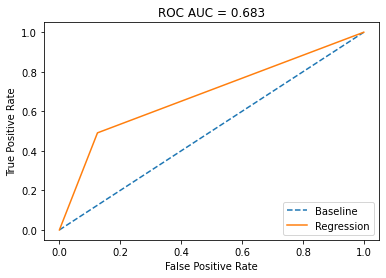

['              precision    recall  f1-score   support',
 '',
 '           0       1.00      0.87      0.93     73408',
 '           1       0.02      0.49      0.04       391',
 '',
 '    accuracy                           0.87     73799',
 '   macro avg       0.51      0.68      0.49     73799',
 'weighted avg       0.99      0.87      0.93     73799',
 '']
CPU times: user 689 ms, sys: 483 ms, total: 1.17 s
Wall time: 3.43 s


In [71]:
%%time
lr = LogisticRegression(n_jobs=-1)

q = cross_val_score(lr, X, y, cv=3, scoring='roc_auc', n_jobs=-1)
print(f'Average quality: {q.mean()}')
print(f'All results: {q}')

show_classification_details(lr.fit(X, y).predict(X), y)

RANDOM FOREST
Average quality: 0.6794813073805028
All results: [0.67760403 0.6826699  0.67816999]


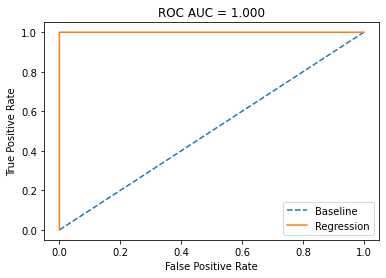

['              precision    recall  f1-score   support',
 '',
 '           0       1.00      1.00      1.00     64429',
 '           1       1.00      1.00      1.00      9370',
 '',
 '    accuracy                           1.00     73799',
 '   macro avg       1.00      1.00      1.00     73799',
 'weighted avg       1.00      1.00      1.00     73799',
 '']
CPU times: user 21.6 s, sys: 263 ms, total: 21.8 s
Wall time: 8.38 s


In [72]:
%%time
print('RANDOM FOREST')
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
q = cross_val_score(rf, X, y, cv=3, scoring='roc_auc', n_jobs=-1)
print(f'Average quality: {q.mean()}')
print(f'All results: {q}')

show_classification_details(rf.fit(X, y).predict(X), y)

лес переобучился

## Оценка качества

Лучшие результаты демонстрирует модель логистической регрессии, попробуем подобрать гиперпараметры для нее

In [73]:
%%time
params_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(0, 4, 10)
}

clf = GridSearchCV(LogisticRegression(n_jobs=-1), params_grid, scoring='roc_auc', cv=3, n_jobs=-1)
clf.fit(X, y)
print('Best Penalty:', clf.best_estimator_.get_params()['penalty'])
print('Best C:', clf.best_estimator_.get_params()['C'])
print('Best score:', clf.best_score_)

/home/user/opt/mambaforge/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Penalty: l2
Best C: 1.0
Best score: 0.7171010860800692
CPU times: user 567 ms, sys: 132 ms, total: 700 ms
Wall time: 10.5 s


## Получение предсказаний

Для этого обучим модель логистической регрессии с параметрами ```penalty: l2, C: 1``` на всей обучающей выборке и предскажем на тестовой

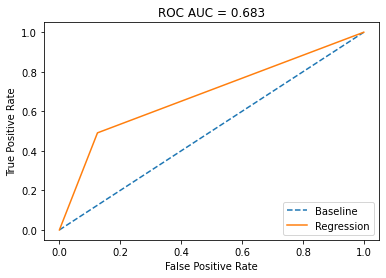

['              precision    recall  f1-score   support',
 '',
 '           0       1.00      0.87      0.93     73408',
 '           1       0.02      0.49      0.04       391',
 '',
 '    accuracy                           0.87     73799',
 '   macro avg       0.51      0.68      0.49     73799',
 'weighted avg       0.99      0.87      0.93     73799',
 '']
[[0.96408034 0.03591966]
 [0.61515274 0.38484726]
 [0.94227592 0.05772408]
 ...
 [0.68567511 0.31432489]
 [0.76570105 0.23429895]
 [0.72418834 0.27581166]]


In [74]:
lr = LogisticRegression(penalty='l2', C=1, n_jobs=-1)
lr.fit(X, y)

show_classification_details(lr.predict(X), y)

predictions = lr.predict_proba(test)
print(predictions)

на самом деле не видно особых улучшений при подобранных параметрах логистической регрессии

In [75]:
test['default'] = predictions[:, 1]

test['default']

client_id
74835     0.035920
17527     0.384847
75683     0.057724
26883     0.071775
28862     0.040642
            ...   
83775     0.301003
106254    0.020036
81852     0.314325
1971      0.234299
69044     0.275812
Name: default, Length: 36349, dtype: float64

In [76]:
test[["default"]].apply(lambda x: round(x)).astype("int").to_csv('submimssion.csv')

In [77]:
# !kaggle competitions submit -c sf-scoring -f submimssion.csv -m "base credit scoring"

## Kaggle score: $0.04067$